# Residual Momentum

*Author: Dacian Peng (彭德鑫)*

*Scripted in: 2022-06*

Data source: *Wind Financial Terminal*

Time consumptions are measured on AMD Ryzen™ 7 6800H

In [2]:
import platform
import pickle
import time
import sklearn
import statsmodels

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from tqdm import tqdm
from pandas import to_datetime as dt
from statsmodels.stats.weightstats import ztest
from sklearn.linear_model import LinearRegression
from IPython.display import display

# simplified Chinese display
plt.rcParams['font.sans-serif'] = ['SimHei']
# plus/minus sign display
plt.rcParams['axes.unicode_minus'] = False

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.DataFrame(index=[''], columns=['Last Run Time', 'Python', 'pandas', 'numpy', 'sklearn', 'statsmodels'], data=[
             [time.asctime(), platform.python_version(), pd.__version__, np.__version__, sklearn.__version__, statsmodels.__version__]])


,Last Run Time,Python,pandas,numpy,sklearn,statsmodels
,Mon Jul 4 14:44:42 2022,3.10.4,1.4.2,1.22.4,1.1.1,0.13.2


## I. Data Preprocessing

### Data loading

I implemented two data loading methods:

- with .xlsx formatted data

- with binary data

We use .xlsx first

In [2]:
def read_Wind(file_path, sheet_name) -> pd.DataFrame or pd.Series:

    '''
    read Wind excel monthly time sequence file, specify the sheet_name
    '''

    data = pd.read_excel(file_path, sheet_name=sheet_name)
    data.columns = data.iloc[2].values
    data.index = data.iloc[:, 0].values
    data = data.iloc[3:, 1:]
    data = data.astype(float)
    data.index = dt(data.index)
    if data.shape[1] == 1:
        return data.iloc[:, 0].to_period('M')
    else:
        return data.to_period('M')


In [3]:
%%time
# close = read_Wind('data.xlsx', 'Sheet1')
# mkt_value = read_Wind('data.xlsx', 'Sheet2')
# pb = read_Wind('data.xlsx', 'Sheet3')
# cash_invest = read_Wind('data.xlsx', 'Sheet4')
# op_profit = read_Wind('data.xlsx', 'Sheet5')


CPU times: total: 0 ns
Wall time: 0 ns


In [5]:
# %%time
# CSI300 = read_Wind('data.xlsx', 'Sheet6')
# # I choose one-year deposit rate as risk free rate
# r_f = read_Wind('data.xlsx', 'Sheet7')
# r_f['2022-06'] = 1.5
# r_f /= (100*12)


CPU times: total: 141 ms
Wall time: 228 ms


Loading data with .xlsx is in poor efficiency

We store the data in binary format

In [7]:
# pickle.dump(close, open('binary_data/close', 'wb'))
# pickle.dump(mkt_value, open('binary_data/mkt_value', 'wb'))
# pickle.dump(pb, open('binary_data/pb', 'wb'))
# pickle.dump(cash_invest, open('binary_data/cash_invest', 'wb'))
# pickle.dump(op_profit, open('binary_data/op_profit', 'wb'))
# pickle.dump(CSI300, open('binary_data/CSI300', 'wb'))
# pickle.dump(r_f, open('binary_data/r_f', 'wb'))


Then load them

In [5]:
%%time

# NOTE, I have already stored them in binary format, you can delete them and try again
# or else, skip the .xlsx loading process and directly use this cell
 
close = pickle.load(open('binary_data/close', 'rb'))
mkt_value = pickle.load(open('binary_data/mkt_value', 'rb'))

# NOTE, Wind does not have book-to-market ratio, I use the reciprocal of pb as bm
# quarterly reported
pb = pickle.load(open('binary_data/pb', 'rb'))
pb = pb.fillna(method='bfill')
bm = 1/pb

# quarterly reported
cash_invest = pickle.load(open('binary_data/cash_invest', 'rb'))
cash_invest = cash_invest.fillna(method='bfill')

# quarterly reported
op_profit = pickle.load(open('binary_data/op_profit', 'rb'))
op_profit = op_profit.fillna(method='bfill')

CSI300 = pickle.load(open('binary_data/CSI300', 'rb'))
r_f = pickle.load(open('binary_data/r_f', 'rb'))


CPU times: total: 15.6 ms
Wall time: 168 ms


50 seconds run time is reduced to less than 0.1 second, program efficiency has been greatly improved

### Percent change and Risk premium

In [7]:
ret = close.pct_change()
ret

,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,871245.BJ,871396.BJ,871553.BJ,871642.BJ,871857.BJ,871970.BJ,871981.BJ,872925.BJ,873169.BJ,873223.BJ
2000-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02,-0.010,0.406,0.011,0.040,0.049,0.160,-0.072,0.066,0.203,0.144,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03,0.003,-0.144,0.184,0.047,-0.029,0.218,-0.143,0.297,0.159,0.167,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04,0.038,-0.017,-0.043,0.017,0.072,-0.134,-0.012,0.049,-0.059,-0.009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05,-0.056,-0.047,0.366,0.095,-0.012,-0.027,-0.076,0.134,-0.032,-0.139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02,-0.005,-0.056,0.034,0.028,0.012,-0.017,0.067,0.074,0.086,-0.010,...,-0.106,-0.071,-0.114,-0.129,0.146,0.000,-0.134,-0.198,0.000,0.000
2022-03,-0.023,-0.003,-0.072,0.027,0.187,0.011,-0.066,-0.187,-0.066,0.198,...,-0.160,-0.124,-0.110,-0.300,-0.162,0.000,-0.198,-0.105,0.000,0.000
2022-04,-0.004,0.012,-0.371,-0.177,-0.153,0.085,-0.122,-0.196,-0.164,-0.076,...,-0.100,-0.185,-0.083,-0.111,-0.124,0.000,-0.140,0.003,-0.422,0.000
2022-05,-0.076,-0.081,-0.232,0.016,0.014,0.070,0.265,0.304,0.256,0.078,...,0.018,0.129,-0.037,0.247,0.062,-0.173,-0.010,0.021,0.014,0.000


In [8]:
r_m = CSI300.pct_change() - r_f
r_m

2000-01      NaN
2000-02      NaN
2000-03      NaN
2000-04      NaN
2000-05      NaN
           ...  
2022-02    0.004
2022-03   -0.078
2022-04   -0.049
2022-05    0.019
2022-06    0.039
Freq: M, Length: 270, dtype: float64

### Grouping

In [9]:
def get_top_and_bottom(row, ascending=True) -> list:
    
    '''
    input: pd.Series, boolean indicator

    if set ascending = True
    return: list, [indexes of the bottom 10% value, indexes of the top 10% value]

    if set ascending = False
    return: list, [indexes of the top 10% value, indexes of the bottom 10% value]

    '''

    length = len(row.dropna())
    if length != 0:
        cut_length = int(length/10)
        top = row.nlargest(cut_length).index
        bottom = row.nsmallest(cut_length).index

        return [bottom, top] if ascending else [top, bottom]


In [10]:
SMB_stocks = mkt_value.apply(lambda row: get_top_and_bottom(row, True),axis=1).dropna()
SMB_stocks

2000-01    [[600837.SH, 000014.SZ, 600647.SH, 600137.SH, ...
2000-02    [[600647.SH, 600137.SH, 000014.SZ, 600792.SH, ...
2000-03    [[600837.SH, 600647.SH, 000014.SZ, 600137.SH, ...
2000-04    [[600837.SH, 600647.SH, 000014.SZ, 600137.SH, ...
2000-05    [[600647.SH, 000014.SZ, 600137.SH, 600898.SH, ...
                                 ...                        
2022-02    [[833580.BJ, 871970.BJ, 835508.BJ, 834765.BJ, ...
2022-03    [[833580.BJ, 834765.BJ, 835508.BJ, 836149.BJ, ...
2022-04    [[835508.BJ, 600091.SH, 833580.BJ, 836149.BJ, ...
2022-05    [[002473.SZ, 600890.SH, 300178.SZ, 600275.SH, ...
2022-06    [[600146.SH, 300312.SZ, 000502.SZ, 002473.SZ, ...
Freq: M, Length: 270, dtype: object

In [11]:
# quarterly reported
HML_stocks = bm.apply(lambda row: get_top_and_bottom(row, False),axis=1).dropna()
HML_stocks

2000-01    [[830839.BJ, 836892.BJ, 830832.BJ, 832089.BJ, ...
2000-02    [[830839.BJ, 836892.BJ, 830832.BJ, 832089.BJ, ...
2000-03    [[830839.BJ, 836892.BJ, 830832.BJ, 832089.BJ, ...
2000-04    [[830839.BJ, 836892.BJ, 830832.BJ, 832089.BJ, ...
2000-05    [[830839.BJ, 836892.BJ, 830832.BJ, 832089.BJ, ...
                                 ...                        
2022-02    [[600016.SH, 600015.SH, 000926.SZ, 601169.SH, ...
2022-03    [[600016.SH, 600015.SH, 600000.SH, 000926.SZ, ...
2022-04    [[600016.SH, 600015.SH, 000926.SZ, 000040.SZ, ...
2022-05    [[600016.SH, 600015.SH, 002146.SZ, 000732.SZ, ...
2022-06    [[300202.SZ, 600015.SH, 300038.SZ, 002146.SZ, ...
Freq: M, Length: 270, dtype: object

In [12]:
# quarterly reported
CMA_stocks = cash_invest.apply(lambda row: get_top_and_bottom(row, True),axis=1).dropna()
CMA_stocks

2000-01    [[601225.SH, 300309.SZ, 000520.SZ, 830799.BJ, ...
2000-02    [[601225.SH, 300309.SZ, 000520.SZ, 830799.BJ, ...
2000-03    [[601225.SH, 300309.SZ, 000520.SZ, 830799.BJ, ...
2000-04    [[601225.SH, 300309.SZ, 000520.SZ, 830799.BJ, ...
2000-05    [[601225.SH, 300309.SZ, 000520.SZ, 830799.BJ, ...
                                 ...                        
2021-11    [[000017.SZ, 000609.SZ, 600193.SH, 600555.SH, ...
2021-12    [[000017.SZ, 000609.SZ, 600193.SH, 600555.SH, ...
2022-01    [[600225.SH, 300937.SZ, 600356.SH, 300952.SZ, ...
2022-02    [[600225.SH, 300937.SZ, 600356.SH, 300952.SZ, ...
2022-03    [[600225.SH, 300937.SZ, 600356.SH, 300952.SZ, ...
Freq: M, Length: 267, dtype: object

In [13]:
# quarterly reported
RMW_stocks = op_profit.apply(lambda row: get_top_and_bottom(row, False),axis=1).dropna()
RMW_stocks

2000-01    [[601816.SH, 600941.SH, 600938.SH, 601857.SH, ...
2000-02    [[601816.SH, 600941.SH, 600938.SH, 601857.SH, ...
2000-03    [[601816.SH, 600941.SH, 600938.SH, 601857.SH, ...
2000-04    [[601816.SH, 600941.SH, 600938.SH, 601857.SH, ...
2000-05    [[601816.SH, 600941.SH, 600938.SH, 601857.SH, ...
                                 ...                        
2021-11    [[601398.SH, 601939.SH, 601288.SH, 601988.SH, ...
2021-12    [[601398.SH, 601939.SH, 601288.SH, 601988.SH, ...
2022-01    [[601398.SH, 601939.SH, 601288.SH, 601988.SH, ...
2022-02    [[601398.SH, 601939.SH, 601288.SH, 601988.SH, ...
2022-03    [[601398.SH, 601939.SH, 601288.SH, 601988.SH, ...
Freq: M, Length: 267, dtype: object

## II. Fama French 5 Factor Model

### Calculate SMB, HML, CMA, RMW

In [14]:
def get_aggregated_value(stocks_set) -> pd.Series:

    '''
    calculate the SMB, HML, CMA, RMW according to stocks set and ret
    '''

    aggregated_value = stocks_set.copy()

    for one_month in stocks_set.index:

        left_stocks = stocks_set.loc[one_month][0]
        right_stocks = stocks_set.loc[one_month][1]

        one_month_ret = ret.loc[one_month]

        left_ret_mean = one_month_ret.loc[left_stocks].mean()
        right_ret_mean = one_month_ret.loc[right_stocks].mean()

        left_minus_right = left_ret_mean - right_ret_mean
        aggregated_value.loc[one_month] = left_minus_right

    return aggregated_value.astype(float)


In [15]:
SMB = get_aggregated_value(SMB_stocks)
HML = get_aggregated_value(HML_stocks)
CMA = get_aggregated_value(CMA_stocks)
RMW = get_aggregated_value(RMW_stocks)

In [16]:
X = pd.concat([r_m, SMB, HML, CMA, RMW], axis=1)
X.columns = ['r_m', 'SMB', 'HML', 'CMA', 'RMW']
X = sm.add_constant(X).dropna()
X

,const,r_m,SMB,HML,CMA,RMW
2002-02,1.000,0.019,0.042,-0.069,0.041,-0.032
2002-03,1.000,0.055,0.029,-0.039,0.059,-0.060
2002-04,1.000,0.030,0.037,-0.044,0.060,-0.024
2002-05,1.000,-0.085,-0.011,-0.058,0.017,-0.023
2002-06,1.000,0.155,-0.099,0.083,-0.081,0.063
...,...,...,...,...,...,...
2021-11,1.000,-0.016,0.068,-0.129,0.108,-0.098
2021-12,1.000,0.022,0.015,0.079,0.011,-0.032
2022-01,1.000,-0.076,0.021,0.055,0.003,0.003
2022-02,1.000,0.004,-0.024,-0.030,0.018,0.035


### Fit Model and get Residual Momentum

In [17]:
residuals = ret.copy()

for stock_code in tqdm(ret.columns):

    stock_returns = ret[stock_code]
    co_time = np.intersect1d(X.index, stock_returns.index)
    linear = sm.OLS(stock_returns.loc[co_time], X.loc[co_time]).fit()
    residuals[stock_code] = linear.resid

residuals = residuals.dropna(how='all')
residuals

100%|██████████| 4829/4829 [00:30<00:00, 158.82it/s]


,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,871245.BJ,871396.BJ,871553.BJ,871642.BJ,871857.BJ,871970.BJ,871981.BJ,872925.BJ,873169.BJ,873223.BJ
2002-02,-0.045,0.015,-0.011,0.021,0.006,0.032,0.068,-0.025,-0.045,0.114,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-03,0.036,-0.031,-0.156,-0.000,-0.073,0.000,0.322,0.213,0.143,0.024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-04,0.009,-0.058,-0.072,-0.094,-0.033,-0.002,-0.202,-0.037,-0.059,-0.018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-05,0.078,0.004,0.092,0.027,-0.013,0.030,-0.095,-0.055,-0.033,-0.092,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-06,0.140,0.010,-0.206,0.407,0.144,0.108,-0.002,0.351,0.187,0.113,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11,-0.053,0.051,-0.013,-0.197,-0.052,0.215,-0.083,-0.234,-0.182,-0.097,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12,-0.095,0.058,-0.009,0.154,0.040,-0.055,0.285,-0.210,-0.002,0.068,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01,0.027,0.078,0.169,0.139,0.049,0.077,-0.076,-0.003,0.013,0.011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02,-0.023,-0.089,0.068,-0.011,0.007,-0.011,0.078,0.092,0.087,-0.033,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
residuals = residuals.rolling(12).sum().dropna(how='all')
residuals

,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,871245.BJ,871396.BJ,871553.BJ,871642.BJ,871857.BJ,871970.BJ,871981.BJ,872925.BJ,873169.BJ,873223.BJ
2003-01,0.152,-0.211,-0.385,0.439,-0.060,0.090,0.003,0.319,0.172,0.008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-02,0.156,-0.207,-0.344,0.445,-0.057,0.022,-0.088,0.349,0.245,-0.139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-03,0.143,-0.062,-0.166,0.508,0.010,0.054,-0.401,0.132,0.135,-0.191,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-04,0.118,-0.002,0.090,0.536,-0.039,0.175,-0.251,0.272,0.288,-0.232,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-05,-0.006,-0.490,-0.058,0.536,-0.063,0.058,-0.136,0.313,0.287,-0.162,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11,0.036,-0.434,-0.278,-0.600,-0.233,0.143,-0.097,1.159,-0.305,-0.253,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12,0.010,-0.260,-0.068,-0.308,-0.158,0.274,0.212,0.979,-0.215,-0.046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01,-0.127,-0.123,0.040,-0.055,-0.011,0.840,0.075,1.060,-0.218,0.086,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02,-0.064,-0.386,0.184,-0.108,-0.051,0.343,0.234,0.735,-0.108,-0.012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## III. Back Test

In [19]:
benchmarks = pd.read_excel('benchmark.xlsx',index_col=0)
print(list(zip(benchmarks.iloc[2].values,benchmarks.iloc[1].values)))
benchmarks.columns = benchmarks.iloc[1]
benchmarks.columns.name = 'Date'
benchmarks = benchmarks.iloc[3:]
benchmarks.index = dt(benchmarks.index).to_period('M')
benchmarks

[('000300.SH', '沪深300'), ('882007.WI', '金融'), ('882011.WI', '房地产'), ('882202.WI', '化工'), ('8841234.WI', '科技龙头指数'), ('8841368.WI', '医药商业指数'), ('8841397.WI', '物流指数'), ('8841163.WI', '大消费指数'), ('882221.WI', '汽车'), ('886040.WI', '教育指数'), ('884871.WI', '数字货币指数')]


Date,沪深300,金融,房地产,化工,科技龙头指数,医药商业指数,物流指数,大消费指数,汽车,教育指数,数字货币指数
2000-01,NaN,1116.519,1149.269,1119.975,NaN,NaN,NaN,NaN,1033.818,1000,NaN
2000-02,NaN,1320.756,1472.024,1267.561,NaN,NaN,NaN,NaN,1129.981,1000,NaN
2000-03,NaN,1329.122,1469.455,1349.297,NaN,NaN,NaN,NaN,1227.723,1000,NaN
2000-04,NaN,1338.225,1471.442,1365.889,NaN,NaN,NaN,NaN,1264.305,1000,NaN
2000-05,NaN,1326.763,1485.648,1405.250,NaN,NaN,NaN,NaN,1309.860,1000,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-02,4581.646,4686.482,3063.318,9072.951,3298.386,22060.684,5640.267,2732.459,13261.149,950.819,1700.130
2022-03,4222.597,4518.200,3365.675,8090.662,2835.845,21248.309,5403.653,2551.586,11860.740,842.632,1682.315
2022-04,4016.241,4266.324,3115.439,7072.966,2419.825,18758.010,5150.557,2439.169,11468.141,670.363,1168.112
2022-05,4091.518,4201.727,2916.681,7858.207,2596.662,20208.609,5778.287,2537.412,14081.164,739.844,1216.266


In [20]:
class BackTest():

    def __init__(self, predict_matrix, price_matrix, group_nums, operation_interval, friction, initial_endowment, leverage, r_f, benchmark, display=True):
        
        self.price_matrix = price_matrix
        self.predict_matrix = predict_matrix.iloc[:-operation_interval]
        self.factor_rank_matrix = self.predict_matrix.rank(axis=1)
        self.time_range = self.price_matrix.index
        self.start_date = self.time_range[0]
        self.end_date = self.time_range[-1]
        self.group_nums = group_nums
        self.operation_interval = operation_interval
        self.friction = friction
        self.initial_endowment = initial_endowment
        self.leverage = leverage
        self.r_f = r_f
        self.benchmark = benchmark.copy()
        self.benchmark = self.benchmark.loc[self.start_date:self.end_date]
        self.benchmark_net_value = benchmarks.apply(lambda column: column/column.dropna()[0])
        self.CSI300 = self.benchmark_net_value.pop('沪深300')
        self.display = display
        self.main()
        
    def main(self):
        self.check_data()
        self.G0_statistics = self.get_statistics(1)
        self.GN_statistics = self.get_statistics(self.group_nums)
        self.execute_strategy()
        self.statistics()
        self.statistics_table_style()
        
    def check_data(self):
        assert self.predict_matrix.shape[1] == self.price_matrix.shape[1], 'stocks list should be the same'
        assert self.predict_matrix.shape[0] + self.operation_interval <= self.price_matrix.shape[0], 'price matrix should contain further price'
        
    def cash_mkt_friction_sequence_holding_matrix(self,group_number):
        '''group_number ranges from 1 to the max group_nums'''
        G_cash_sequence = pd.Series(np.zeros(len(self.time_range)),index=self.time_range,dtype='object')
        G_friction_sequence = G_cash_sequence.copy()
        G_market_value_sequence = G_cash_sequence.copy()
        G_holdings_matrix = self.price_matrix.copy()
        G_holdings_matrix[:] = 0
        
        for index_num,day in enumerate(self.factor_rank_matrix.index):
            if ~pd.isna(self.factor_rank_matrix.loc[day]).all():
                numbered_factor_vector = pd.cut(self.factor_rank_matrix.loc[day], self.group_nums, labels=False)
                
                G = numbered_factor_vector.index[numbered_factor_vector == group_number-1]
                
                T_price = self.price_matrix.loc[day]
                T_plus_interval_price = self.price_matrix.iloc[index_num+self.operation_interval]
                
                G_T_Δcash = self.leverage*self.initial_endowment/self.operation_interval
                G_cash_sequence[day] += G_T_Δcash
                G_friction_sequence[day] += self.friction*G_T_Δcash
                G_T_Δholding = G_T_Δcash/(T_price.loc[G]*len(G))
                
                G_T_plus_interval_Δcash = (G_T_Δholding*T_plus_interval_price.loc[G]).sum()
                G_friction_sequence[index_num+self.operation_interval] += self.friction*G_T_plus_interval_Δcash
                G_cash_sequence[index_num+self.operation_interval] -= G_T_plus_interval_Δcash
                
                G_holdings_matrix.loc[day,G] -= G_T_Δholding
                G_holdings_matrix.iloc[index_num+self.operation_interval].loc[G] += G_T_Δholding

        G_friction_sequence = G_friction_sequence.cumsum()
        G_theoretical_cash_sequence = G_cash_sequence.cumsum()
        G_real_cash_sequence = G_theoretical_cash_sequence-G_friction_sequence
        G_market_value_sequence = (G_holdings_matrix.cumsum()*self.price_matrix).sum(axis=1)
        
        return G_real_cash_sequence, G_theoretical_cash_sequence, G_market_value_sequence, G_friction_sequence, G_holdings_matrix
        
    def get_statistics(self,group_number):
        G_real_cash_sequence, G_theoretical_cash_sequence, G_market_value_sequence, G_friction_sequence, G_holdings_matrix = self.cash_mkt_friction_sequence_holding_matrix(group_number)
        
        G_value = G_real_cash_sequence+G_market_value_sequence
        G_wealth = G_value+self.initial_endowment
        G_net_value = G_wealth/self.initial_endowment
        mapping_dict = {'cash': G_real_cash_sequence, 'mkt': G_market_value_sequence, 'theoretical': G_theoretical_cash_sequence, 'friction': G_friction_sequence, 
            'value': G_value, 'wealth': G_wealth, 'net_value': G_net_value, 'holdings': G_holdings_matrix}
        return mapping_dict
        
    def execute_strategy(self):
        G0_theoretical_value = self.G0_statistics['theoretical'] + self.G0_statistics['mkt']
        GN_theoretical_value = self.GN_statistics['theoretical'] + self.GN_statistics['mkt']
        self.strategy_value = GN_theoretical_value - G0_theoretical_value - self.GN_statistics['friction'] - self.G0_statistics['friction']
        self.strategy_net_value = 1+self.strategy_value/self.initial_endowment
        self.strategy_net_value_pct_change = self.strategy_net_value.pct_change().dropna()
    
    @property
    def net_value(self):
        plt.figure(figsize=(24,10))
        self.strategy_net_value.plot(label='strategy')
        self.G0_statistics['net_value'].plot(label='G0')
        self.GN_statistics['net_value'].plot(label='GN')
        self.CSI300.plot(label='CSI300')
        self.benchmark_net_value.apply(lambda x:plt.plot(x,alpha=.2,label=x.name))
        plt.legend()
        plt.show()
        
    @property
    def strategy_significance(self):
        self.z = ztest(self.strategy_net_value,value=1,alternative='larger')
        print(f'z-statistic (H1: net value>1): {self.z[0].round(4)}, one-sided p-value: {self.z[1].round(4)}') if self.display else None
        
    def get_sharpe_ratio(self, series):
        ret_series = series.pct_change()
        return (ret_series.mean()-self.r_f/252)/ret_series.std()
    
    @property
    def sharpe_ratio(self):
        self.SR = self.get_sharpe_ratio(self.strategy_net_value)
        print(f'Sharpe ratio (daily type): {np.array(self.SR).round(4)}') if self.display else None
        
    def get_MDD(self,window):
        draw_down = self.strategy_net_value.rolling(window).apply(lambda x: (x[-1] - x.max())/x[-1])
        self.MDD = draw_down.min()
    
    def maximum_draw_down(self,window=25):
        '''default window = 25'''
        try:
            self.MDD
        except AttributeError:
            self.get_MDD(window)
        print(f'{window} days maximum draw down: {100*np.array(self.MDD).round(4)}%') if self.display else None

    def fit_lr(self):

        strategy_ret = self.strategy_net_value.pct_change().dropna()
        time_span = strategy_ret.index
        X = self.CSI300.pct_change().loc[time_span].dropna()
        y = strategy_ret.loc[X.index].values
        X = X.values.reshape(-1,1)
        self.model = LinearRegression().fit(X,y)
        self._β = self.model.coef_[0]
        self._α = self.model.intercept_ + self._β*self.r_f/252
    
    def initialize_lr(self):
        try:
            self.model
        except AttributeError:
            self.fit_lr()
    
    @property
    def β(self):
        self.initialize_lr()
        print(f'β: {np.array(self._β).round(4)}') if self.display else None
        
    @property
    def α(self):
        self.initialize_lr()
        print(f'daily α: {np.array(self._α).round(4)}') if self.display else None
        
    def get_treynor_ratio(self, series):
        self.initialize_lr()
        ret_series = series.pct_change()
        return (ret_series.mean()-self.r_f/252)/self._β
    
    @property
    def treynor_ratio(self):
        self.TR = self.get_treynor_ratio(self.strategy_net_value)
        print(f'Treynor ratio (daily type): {np.array(self.TR).round(4)}') if self.display else None
        
    @property
    def win_rate(self):
        self.WR = self.strategy_net_value.rolling(self.operation_interval).apply(lambda period_values: True if period_values[-1]>period_values[0] else False).sum()/len(self.time_range)
        print(f'Win rate: {100*np.array(self.WR).round(4)}%') if self.display else None

    def get_calmar_ratio(self, window, series):
        try:
            self.MDD
        except AttributeError:
            self.get_MDD(window)
        ret_series = series.pct_change()
        return (ret_series.mean()-self.r_f/252)/(-self.MDD/window)
    
    def calmar_ratio(self, window=25):
        self.CR = self.get_calmar_ratio(window, self.strategy_net_value)
        print(f'Calmar ratio (daily type): {np.array(self.CR).round(4)}') if self.display else None

    def value_at_risk(self,percent=.05):
        self.Var_proportional = self.strategy_net_value_pct_change.sort_values()[int(percent*len(self.time_range))]
        self.Var = -self.Var_proportional*self.initial_endowment
        print(f'Value at {percent*100}% risk, {int(self.initial_endowment)} initial endowment: {np.array(self.Var).round(4)}') if self.display else None

    def expected_shortfall(self,percent=.05):
        self.ES_proportional = self.strategy_net_value_pct_change.sort_values()[:int(percent*len(self.time_range))].mean()
        self.ES = -self.ES_proportional*self.initial_endowment
        print(f'Expected Shortfall with {percent*100}% tail risk, {int(self.initial_endowment)} initial endowment: {np.array(self.ES).round(4)}') if self.display else None

    @property
    def yearly_return(self):
        self.DR = self.strategy_net_value[-1]**(255/len(self.time_range))-1
        print(f'Compounded yearly return: {np.array(self.DR).round(4)}') if self.display else None

    @property
    def standard_deviation(self):
        self.std = self.strategy_net_value.std()
        print(f'Standard deviation (daily type): {np.array(self.std).round(4)}') if self.display else None

    @property
    def improvement(self):
        self.earning_multiple_to_CSI300 = (self.strategy_net_value[-1]-1)/(self.CSI300[-1]-1)
        self.EMB = self.earning_multiple_to_CSI300
        self.volatility_multiple_to_CSI300 = self.strategy_net_value.std()/self.CSI300.std()
        self.VMB = self.volatility_multiple_to_CSI300
        print(f'Total earning multiple compared to CSI300: {np.array(self.EMB).round(4)}') if self.display else None
        print(f'Volatility multiple compared to CSI300 (daily std.): {np.array(self.VMB).round(4)}') if self.display else None
        
    def statistics(self, window=25, percent=.05):
        self.net_value
        self.strategy_significance
        self.sharpe_ratio
        self.treynor_ratio
        self.β
        self.α
        self.maximum_draw_down(window)
        self.win_rate
        self.calmar_ratio(window)
        self.value_at_risk(percent)
        self.expected_shortfall(percent)
        self.yearly_return
        self.standard_deviation
        self.improvement
    
    def statistics_table_style(self, window=25, percent=.05):
        index = ['daily sharpe ratio', 'daily treynor ratio', 'β', 'daily α', f'{window} window MDD', 'win rate', 'calmar ratio',
                f'{int(percent*100)}% VaR', f'{int(percent*100)}% ES', 'compounded yearly return', 'daily std', 'CSI300 earning multiple', 'CSI300 daily volatility multiple']
        result = [self.SR, self.TR, self._β, self._α,
                f'{100*np.array(self.MDD).round(4)}%', f'{100*np.array(self.WR).round(4)}%', self.CR, self.Var, self.ES, self.DR, self.std, self.EMB, self.VMB]
        table = pd.DataFrame(result, index=index).T
        table.index = ['']
        display(table)


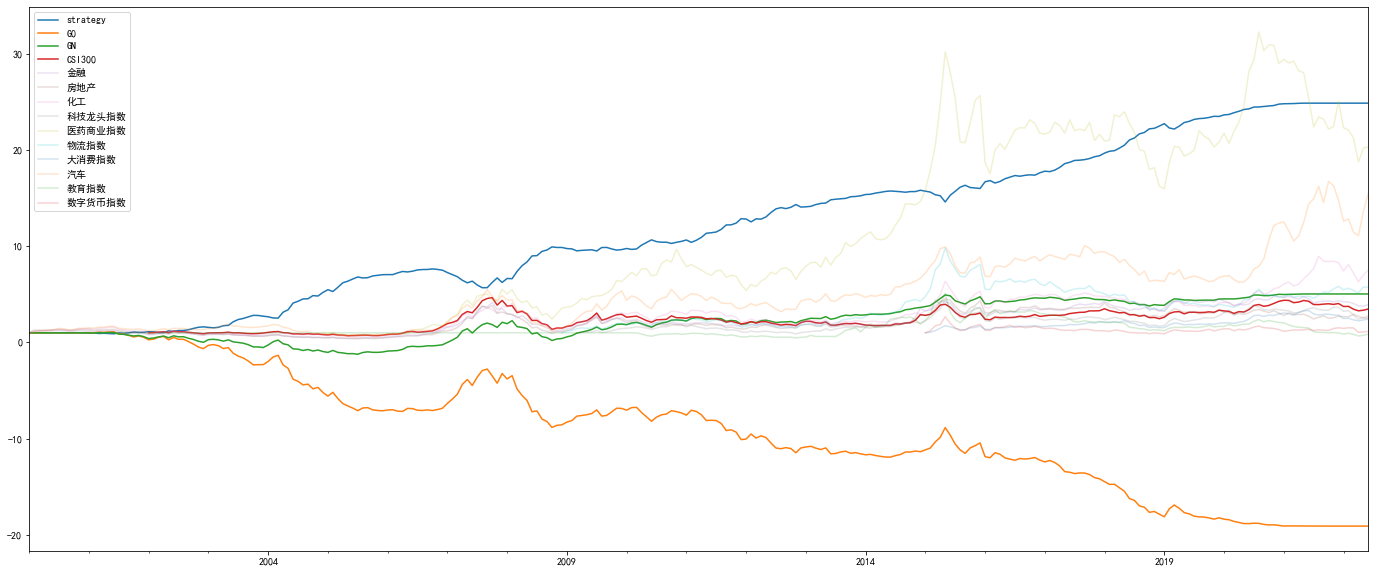

z-statistic (H1: net value>1): 23.4359, one-sided p-value: 0.0
Sharpe ratio (daily type): 0.33
Treynor ratio (daily type): -0.0478
β: -0.2639
daily α: 0.0156
25 days maximum draw down: -34.36%
Win rate: 82.59%
Calmar ratio (daily type): 0.9182
Value at 5.0% risk, 100000 initial endowment: 3462.6052
Expected Shortfall with 5.0% tail risk, 100000 initial endowment: 4913.4112
Compounded yearly return: 19.8036
Standard deviation (daily type): 7.7263
Total earning multiple compared to CSI300: 9.6303
Volatility multiple compared to CSI300 (daily std.): 7.5648


,daily sharpe ratio,daily treynor ratio,β,daily α,25 window MDD,win rate,calmar ratio,5% VaR,5% ES,compounded yearly return,daily std,CSI300 earning multiple,CSI300 daily volatility multiple
,0.330,-0.048,-0.264,0.016,-34.36%,82.59%,0.918,3462.605,4913.411,19.804,7.726,9.630,7.565


In [21]:
BackTest(residuals, close, group_nums=10, operation_interval=10, friction=.002, initial_endowment=1e5, leverage=1, r_f=0.02, benchmark=benchmarks, display=True)